In [58]:
using Turing
using Random
using StatsPlots
using LinearAlgebra

# 乱数シードを設定
Random.seed!(1234)

# データの生成
N = 100  # サンプル数
# 特徴量（勉強時間と睡眠時間）
hours_pass = rand(Normal(6, 2), N)   # 合格者の勉強時間
sleep_pass = rand(Normal(7, 1), N)   # 合格者の睡眠時間
hours_fail = rand(Normal(3, 1), N)   # 不合格者の勉強時間
sleep_fail = rand(Normal(5, 1), N)   # 不合格者の睡眠時間

100-element Vector{Float64}:
 5.29167325753134
 4.786390328822295
 4.577691403899925
 5.416176401771538
 4.629759079299614
 4.927140799499371
 4.7264815476168325
 5.712119367409955
 5.759844150396753
 4.135573443758123
 5.606230454226334
 5.82843842348668
 4.266233397078629
 ⋮
 4.903694546041763
 5.0032444461674
 6.3694182572946465
 5.1090721656784925
 5.1561544691313665
 4.013029835507
 5.7023223680500825
 5.3209061752969795
 5.310306390513125
 5.507985968275232
 5.746834006415206
 3.7865686124586757

In [59]:
X_pass = hcat(hours_pass, sleep_pass)
X_fail = hcat(hours_fail, sleep_fail)

100×2 Matrix{Float64}:
 3.88325   5.29167
 3.20034   4.78639
 2.57831   4.57769
 5.23396   5.41618
 2.11825   4.62976
 1.64001   4.92714
 1.45015   4.72648
 4.65567   5.71212
 2.9757    5.75984
 2.16366   4.13557
 1.70773   5.60623
 2.75915   5.82844
 0.729805  4.26623
 ⋮         
 4.38702   4.90369
 4.72698   5.00324
 2.11473   6.36942
 3.82812   5.10907
 5.53705   5.15615
 2.97161   4.01303
 3.68589   5.70232
 4.0275    5.32091
 2.93186   5.31031
 2.07494   5.50799
 2.83402   5.74683
 3.16398   3.78657

In [60]:
X = vcat(X_pass, X_fail)  # 特徴量を縦に結合

200×2 Matrix{Float64}:
  7.94131  8.20821
  4.04156  8.31215
  7.80372  7.41641
  5.93439  6.86279
  4.79842  7.04717
  3.10965  7.13851
 11.4148   7.6099
  9.0489   6.91043
  7.51961  6.98779
  4.23713  6.3793
  7.41199  8.43362
  8.18311  7.48653
  7.743    6.51487
  ⋮        
  4.38702  4.90369
  4.72698  5.00324
  2.11473  6.36942
  3.82812  5.10907
  5.53705  5.15615
  2.97161  4.01303
  3.68589  5.70232
  4.0275   5.32091
  2.93186  5.31031
  2.07494  5.50799
  2.83402  5.74683
  3.16398  3.78657

In [61]:
y = vcat(fill(1, N), fill(0, N))

200-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [62]:
@model function naive_bayes(X, y, N, D)
    # クラスごとの事前確率
    p_pass ~ Beta(1, 1)  # 合格の事前確率
    p_fail = 1 - p_pass  # 不合格の事前確率

    # 合格/不合格の特徴量分布
    μ_pass ~ filldist(Normal(0, 5), D)
    μ_fail ~ filldist(Normal(0, 5), D)
    σ_pass ~ filldist(Gamma(2, 2), D)
    σ_fail ~ filldist(Gamma(2, 2), D)

    for n in 1:N
        if y[n] == 1
            X[n, :] ~ MvNormal(μ_pass, diagm(σ_pass))
        else
            X[n, :] ~ MvNormal(μ_fail, diagm(σ_fail))
        end
    end
end

naive_bayes (generic function with 2 methods)

┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


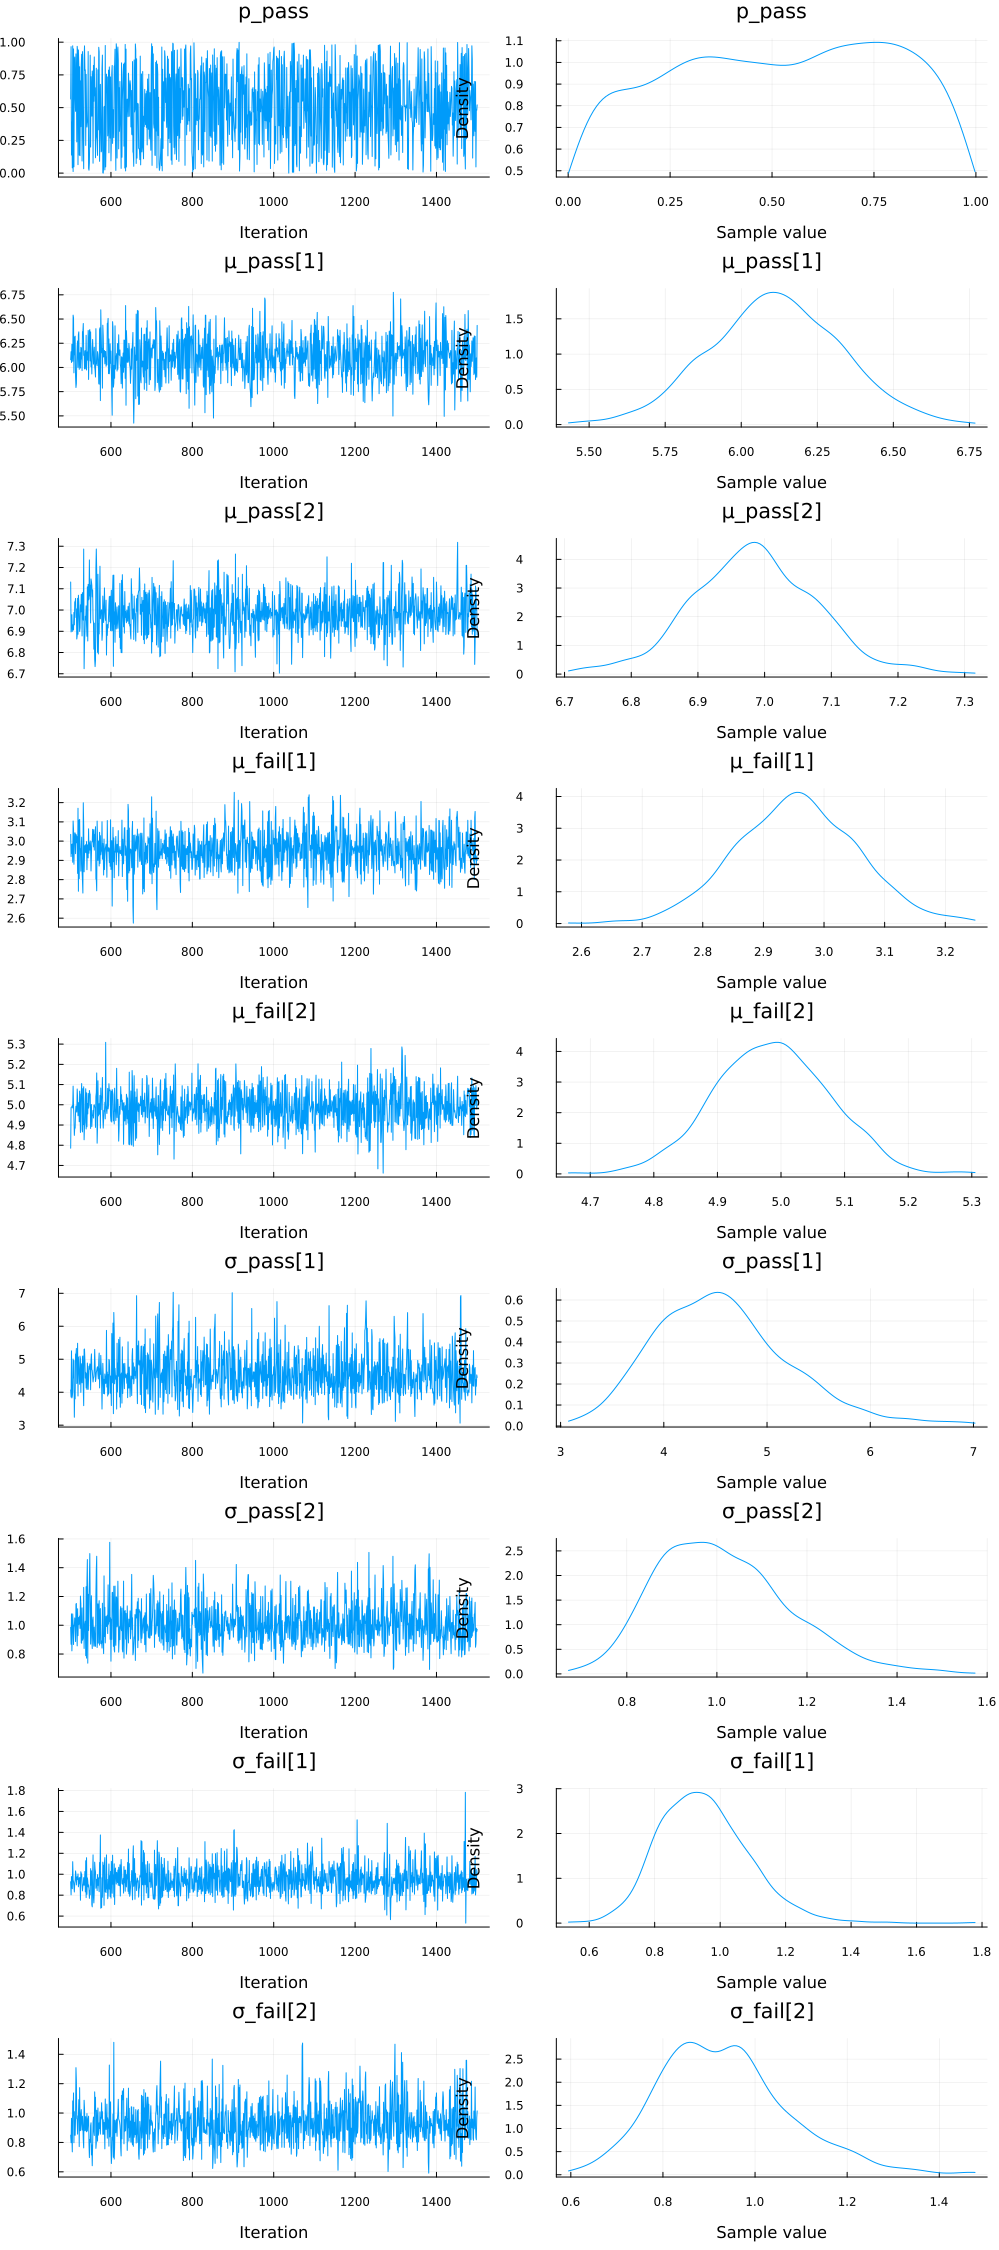

In [63]:
# モデルの作成
nb_model = naive_bayes(X, y, 2N, 2)  # データ数=200, 特徴量次元=2

# 推論を実行
chain = sample(nb_model, NUTS(0.65), 1000)

# 結果をプロット
display(plot(chain))

In [64]:
# 結果の要約
summarystats(chain)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

      p_pass    0.5105    0.2853    0.0076   1396.8812   681.2306    1.0050    ⋯
   μ_pass[1]    6.1113    0.2163    0.0060   1276.0568   700.0215    1.0004    ⋯
   μ_pass[2]    6.9841    0.0944    0.0027   1215.3738   630.8421    1.0086    ⋯
   μ_fail[1]    2.9547    0.1006    0.0027   1391.9721   648.3496    1.0001    ⋯
   μ_fail[2]    4.9859    0.0905    0.0024   1461.3714   658.5801    1.0061    ⋯
   σ_pass[1]    4.5743    0.6688    0.0192   1370.6895   505.8044    1.0003    ⋯
   σ_pass[2]    1.0135    0.1465    0.0042   1288.6203   757.1258    0.9991    ⋯
   σ_fail[1]    0.9506    0.1381    0.0035   1758.1627   703.9525    0.9994    ⋯
   σ_fail[2]    0.9331    0.1425    0.0044   1048.2628   684.0279    1.0037    ⋯
                                                                1 column omitted


In [65]:
quantile(chain)

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      p_pass    0.0244    0.2745    0.5119    0.7580    0.9721
   μ_pass[1]    5.6789    5.9723    6.1104    6.2596    6.5392
   μ_pass[2]    6.7960    6.9221    6.9829    7.0462    7.1776
   μ_fail[1]    2.7595    2.8860    2.9539    3.0221    3.1550
   μ_fail[2]    4.8133    4.9224    4.9878    5.0461    5.1522
   σ_pass[1]    3.4955    4.0958    4.5107    4.9530    6.1083
   σ_pass[2]    0.7792    0.9039    0.9958    1.1011    1.3491
   σ_fail[1]    0.7164    0.8516    0.9382    1.0351    1.2449
   σ_fail[2]    0.6884    0.8335    0.9213    1.0136    1.2416
